In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project 1

/content/drive/MyDrive/project 1


In [3]:
%pwd

'/content/drive/MyDrive/project 1'

In [4]:
%pip install import-ipynb
%pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00


### Task 1

#### 1. Basic Concepts
1. The purpose of using dataset distillation in this paper is to reduce the training costs while maintaining the high performance on various machine learning tasks. The authors introduce Dataset Distillation with Attention Maching (DataDAM) to condense large datasets into smaller synthetic dataset that retain the critical information, allowing models trained on the synthetic set to achieve similar accuracy as those trained on the full dataset.
2.  The advantages are: (page 2)
- Efficient end-to-end dataset distillation: This highlights the ability of DataDAM to closely approximate the distribution of the real dataset while keeping **computational costs low**.
- Improved accuracy and scalability: DataDAM demonstrate the performance across multiple benchmark dataset and reduces the training costs by up to 100x, while also allowing for cross-architecture generation. This makes it more scalable and flexible for real-world application.
- Enhancement of downstream application: DATADAM's distilled data improves memory efficiency in continual learning tasks and accelerates neural architectures search(NAS) by providing a more representative proxy dataset, enabling a faster and more efficient learning process.  
3. The novelty includes: (page 2)
- Multiple Randomly Initialized DNNs: DataDAM uses multiple randomly initialized deep neural networks to extract meaningful representations from both real and synthetic datasets, which is different from methods that rely on pre-trained models
- Spatial attention matching (SAM): The SAM module align the most discriminative feature maps from real and synthetic datasets, reducing the gap between the dataset.
- Last-Layer Feature Alignment: It reduces disparities in the last-layer feature distributions between the real and synthetic datasets by using a complementary loss as a regularizer, ensuring high-level abstract representations are similar.
- Bias-Free Synthetic Data: The synthetic data generated by DataDAM does not introduce any bias, which is a significant improvement over prior methods, ensuring better generalization and performance.
4. The methodology of DataDAM is centered on efficiently distilling datasets through attention matching: (page 4)
- Initialization of Synthetic Dataset: The process starts by initializing a synthetic dataset, which can be done through random noise or by sampling real data.
- Feature Extraction: Real and synthetic datasets are passed through randomly initialized deep neural networks, and features are extracted at multiple layers.
- Spatial Attention Matching (SAM): Attention maps are computed for each layer, excluding the final layer. These attention maps focus on the most discriminative regions of the input image.
- Loss Functions:
    - SAM Loss (LSAM): This loss minimizes the distance between attention maps of real and synthetic datasets across layers.
    - Maximum Mean Discrepancy Loss (MMD): This complementary loss aligns the last-layer feature distributions of the two datasets, ensuring the high-level abstract information is captured.
- Optimization: The synthetic dataset is optimized using a combination of the SAM loss and LMMD loss to minimize the difference between real and synthetic data.
5. (page 8)
- Continual Learning: DataDAM’s ability to condense datasets efficiently makes it highly useful in continual learning scenarios, where a model must learn incrementally while preventing catastrophic forgetting. By using the distilled datasets as a replay buffer, DataDAM can significantly improve memory efficiency and performance in incremental learning tasks.
- Neural Architecture Search (NAS): The synthetic datasets generated by DataDAM can serve as proxies in NAS tasks, allowing faster evaluation of model architectures. This leads to a significant reduction in computational costs and time during the model search process, making NAS more feasible in real-world applications.

#### 2. Data Distillation Learning - MHIST
##### a) Train model with origianl dataset


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

In [6]:
import import_ipynb
from utils import get_network, get_time

In [8]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def training_model(model, optimizer, scheduler, criterion, train_loader):
    torch.cuda.empty_cache()
    for epoch in range(20):
        model.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            torch.cuda.empty_cache()
        scheduler.step()

        print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")


In [11]:
training_model(model, optimizer, scheduler, criterion, train_loader)

Epoch [1/20], Loss: 0.5834312415808097
Epoch [2/20], Loss: 0.5292203050920333
Epoch [3/20], Loss: 0.46430938615196055
Epoch [4/20], Loss: 0.4222520293586556
Epoch [5/20], Loss: 0.39492889941423787
Epoch [6/20], Loss: 0.34154377919504014
Epoch [7/20], Loss: 0.29854089504685893
Epoch [8/20], Loss: 0.2443035088462391
Epoch [9/20], Loss: 0.20313632208725502
Epoch [10/20], Loss: 0.13901353432529273
Epoch [11/20], Loss: 0.10551055303592792
Epoch [12/20], Loss: 0.048879518573996666
Epoch [13/20], Loss: 0.02232834735093103
Epoch [14/20], Loss: 0.013103432763239433
Epoch [15/20], Loss: 0.008874510509957528
Epoch [16/20], Loss: 0.007419609559550025
Epoch [17/20], Loss: 0.006591533698869505
Epoch [18/20], Loss: 0.006164978656532436
Epoch [19/20], Loss: 0.005948339231397913
Epoch [20/20], Loss: 0.005852912034111461


In [12]:
model_path = 'models/mhist_original_grey.pth'
torch.save(model.state_dict(), model_path)

In [13]:
model_path = 'models/mhist_original_grey.pth'
model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
model.load_state_dict(torch.load(model_path))


<ipython-input-13-6d8a4723839c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.long()
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [15]:
evaluate_model(model, test_loader)

Test Accuracy: 81.27%


In [20]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (1, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"MACs: {macs}, Parameters: {params}")

ConvNet(
  888.83 k, 100.000% Params, 2.65 GMac, 99.336% MACs, 
  (features): Sequential(
    888.58 k, 99.971% Params, 2.65 GMac, 99.336% MACs, 
    (0): Conv2d(1.28 k, 0.144% Params, 66.54 MMac, 2.492% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.029% Params, 13.31 MMac, 0.498% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.65 MMac, 0.249% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.65 MMac, 0.249% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.604% Params, 1.92 GMac, 71.824% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.33 MMac, 0.125% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.66 MMac, 0.062% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.66 MMac, 0.062% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.604% Params, 479.5 MMac, 17.956% MACs, 128, 1

In [21]:
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(model, (1, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  888.83 k, 100.000% Params, 2.65 GMac, 99.336% MACs, 
  (features): Sequential(
    888.58 k, 99.971% Params, 2.65 GMac, 99.336% MACs, 
    (0): Conv2d(1.28 k, 0.144% Params, 66.54 MMac, 2.492% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.029% Params, 13.31 MMac, 0.498% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.65 MMac, 0.249% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.65 MMac, 0.249% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.604% Params, 1.92 GMac, 71.824% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.33 MMac, 0.125% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.66 MMac, 0.062% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.66 MMac, 0.062% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.604% Params, 479.5 MMac, 17.956% MACs, 128, 1

##### b) Learn the synthetic dataset with attention matching algorithm

In [26]:
# real dataset loader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=128, shuffle=True)

In [38]:
import torch
import random
from torch import optim

num_classes = 2
num_images_per_class = 50
img_size = (1, 224, 224)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_synthetic_dataset(real_dataset, num_classes=2, images_per_class=50, K=200, eta_s=0.1,
                               zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):

        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            img_real = real_dataset[i][0].to(device)

            synthetic_versions = []
            for _ in range(K):
                synthetic_image = img_real.clone().detach().requires_grad_(True)
                synthetic_versions.append(synthetic_image)

            for synthetic_image in synthetic_versions:
                optimizer_condensed = optim.SGD([synthetic_image], lr=eta_s)

                for _ in range(zeta_s):
                    optimizer_condensed.zero_grad()
                    loss = torch.nn.functional.mse_loss(synthetic_image, img_real)
                    loss.backward()
                    optimizer_condensed.step()

            final_synthetic_image = torch.mean(torch.stack(synthetic_versions), dim=0).detach()

            synthetic_images.append(final_synthetic_image)
            synthetic_labels.append(class_id)

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn


In [28]:
#step 2: optimizer
img_syn, labels_syn = generate_synthetic_dataset(real_dataset, 2)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

In [29]:
# step 3: set up model - ConvNET - 7 in this case
# freeze the model's weights so that only the synthetic dataset is updated

model_path = 'models/mhist_original_grey.pth'
net = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)
net.train()

for param in list(net.parameters()):
    param.requires_grad = False

<ipython-input-29-da54f3140c0f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))


In [30]:
# step 5: hook
# Using hook to extract the activations from the layers (attention maps) to compare the attention maps from real to synthetic
activations = {}


def get_activation(name):
    def hook_func(m, inp, op):
        activations[name] = op.detach()

    return hook_func


''' Defining the Refresh Function to store Activations and reset Collection '''


def refresh_activations(activations):
    model_set_activations = []  # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations


def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return


def attach_hooks(net):
    hooks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(get_activation(name)))
    return hooks


In [31]:
# step 6: Attention Matching Map
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param == 0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)

    elif param == 1:
        attention_map = torch.sum(torch.abs(feature_set) ** exp, dim=1)

    elif param == 2:
        attention_map = torch.max(torch.abs(feature_set) ** exp, dim=1)

    if norm == 'l2':
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map = attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2, dim=1)

    return normalized_attention_maps

In [32]:
# step 7: error function
def error(real, syn, err_type="MSE"):
    if err_type == "MSE":
        err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0)) ** 2)
    elif err_type == "MAE":
        err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
    elif err_type == "MSE_B":
        err = torch.sum(
            (torch.mean(real.reshape(2, -1).cpu(), dim=1) - torch.mean(syn.reshape(2, -1).cpu(), dim=1)) ** 2)
    else:
        raise ValueError("Invalid error type")
    return err

In [33]:
# step 8: training loop
def train_dataset(img_syn, labels_syn, activations={}):
    num_iterations = 10
    learning_rate_model = 0.01

    losses = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        images_syn_all = []
        labels_syn_all = []
        images_real_all = []
        labels_real_all = []

        for c in range(num_classes):
            img_real, label_real = next(iter(real_loader))
            img_real = img_real.to(device)
            img_syn_per_class = img_syn[c * num_images_per_class:(c + 1) * num_images_per_class].to(device)
            label_syn_per_class = labels_syn[c * num_images_per_class:(c + 1) * num_images_per_class]

            images_real_all.append(img_real)
            labels_real_all.append(label_real)
            images_syn_all.append(img_syn_per_class)
            labels_syn_all.append(label_syn_per_class)

        images_real_all = torch.cat(images_real_all, dim=0)
        labels_real_all = torch.cat(labels_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)
        labels_syn_all = torch.cat(labels_syn_all, dim=0)

        net.train()
        hooks = attach_hooks(net)

        output_real = net(images_real_all)[0]
        activations, original_model_set_activations = refresh_activations(activations)

        output_syn = net(images_syn_all)[0]
        activations, syn_model_set_activations = refresh_activations(activations)
        delete_hooks(hooks)

        length_of_network = len(original_model_set_activations)

        loss = torch.tensor(0.0)
        mid_loss = 0
        out_loss = 0
        loss_avg = 0

        for layer in range(length_of_network - 1):
            real_attention = get_attention(original_model_set_activations[layer], param=1, exp=1, norm='l2')
            syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

            tl = 100 * error(real_attention, syn_attention, err_type="MSE_B")
            loss += tl
            mid_loss += tl.item()

        output_loss = 100 * 0.01 * error(output_real, output_syn, err_type="MSE_B")
        loss += output_loss
        out_loss += output_loss.item()

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        torch.cuda.empty_cache()

        loss_avg /= (num_classes)
        out_loss /= (num_classes)
        mid_loss /= (num_classes)
        losses.append((loss_avg, out_loss, mid_loss))
        if iteration % 10 == 0:
            print('%s iter = %05d, loss = %.4f' % (get_time(), iteration, loss_avg))

    print("training completed.")
    return img_syn, labels_syn, losses


In [34]:
def save_results(img_syn, labels_syn, losses, noise_type):
    save_path = f"mhist_result/grey_{noise_type}_synthetic_dataset.pt"

    torch.save({'images': img_syn, 'labels': labels_syn}, save_path)

    print(f"Synthetic dataset saved to {save_path}")

    loss_log_path = f"mhist_result/{noise_type}_training_losses.txt"
    with open(loss_log_path, "w") as f:
        for epoch, loss in enumerate(losses):
            f.write(f"Iteration {epoch}: Loss = {loss}\n")

    print(f"Training losses saved to {loss_log_path}")

In [39]:
num_classes = 2

img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, '')

Iteration 1/10
[2024-10-26 03:42:30] iter = 00000, loss = 1.0533
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/grey__synthetic_dataset.pt
Training losses saved to mhist_result/_training_losses.txt


##### 2c) Visualize the condensed images per class

In [20]:
import torch
import os
import matplotlib.pyplot as plt

def display_image_grid(img_syn, labels_syn, noise_type):
    # Create directory to save grid images
    save_dir = f"mhist_result/grey_{noise_type}_grid"
    os.makedirs(save_dir, exist_ok=True)

    num_samples_per_class = 50

    class_dict = {}

    for img, label in zip(img_syn, labels_syn):
        label = label.item()
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)

    for class_label, images in class_dict.items():
        selected_images = images[:num_samples_per_class]

        fig, axs = plt.subplots(5, 10, figsize=(15, 7))
        fig.suptitle(f"Class {class_label} - {noise_type}", fontsize=16)
        fig.patch.set_facecolor('white')

        # Display each image
        for idx, img in enumerate(selected_images):
            img_np = img.permute(1, 2, 0).detach().numpy()
            axs[idx // 10, idx % 10].imshow(img_np, cmap='gray')
            axs[idx // 10, idx % 10].axis('off')
            axs[idx // 10, idx % 10].set_facecolor('white')

        # Display the grid of images
        plt.show()

        # Save the grid of images as a single image file for report
        grid_save_path = os.path.join(save_dir, f"class_{class_label}_grid.png")
        fig.savefig(grid_save_path, facecolor='white')  # Save grid with white background
        plt.close()

    print(f"Image grids saved to {save_dir}")

# Call the function with your loaded data

<ipython-input-21-b5c8705222c6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey__synthetic_dataset.pt')


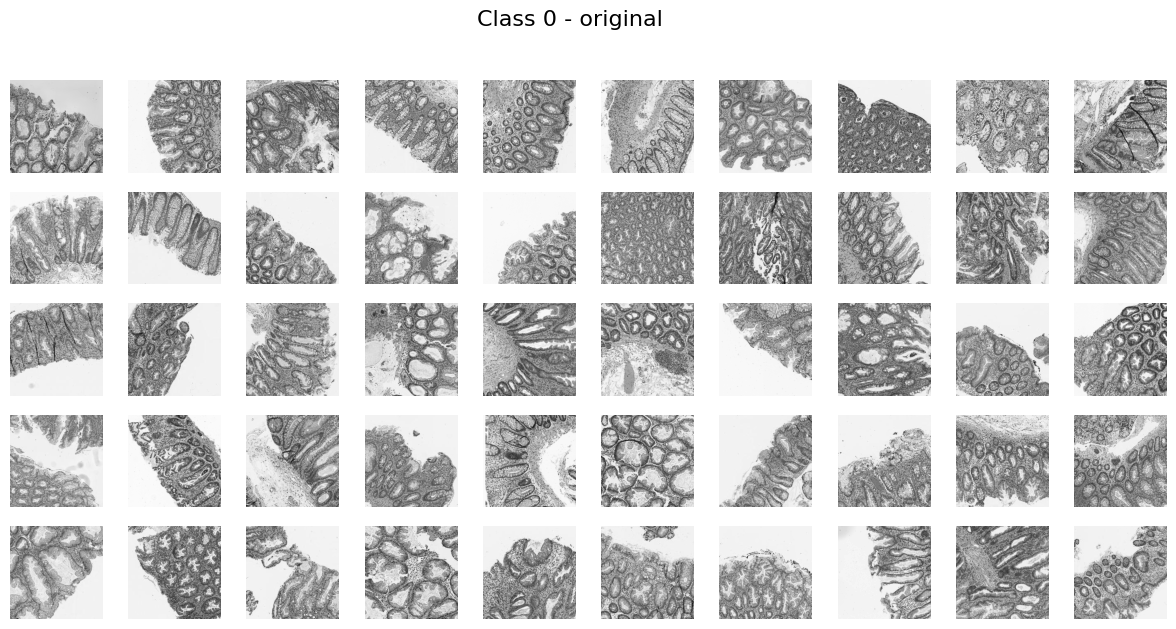

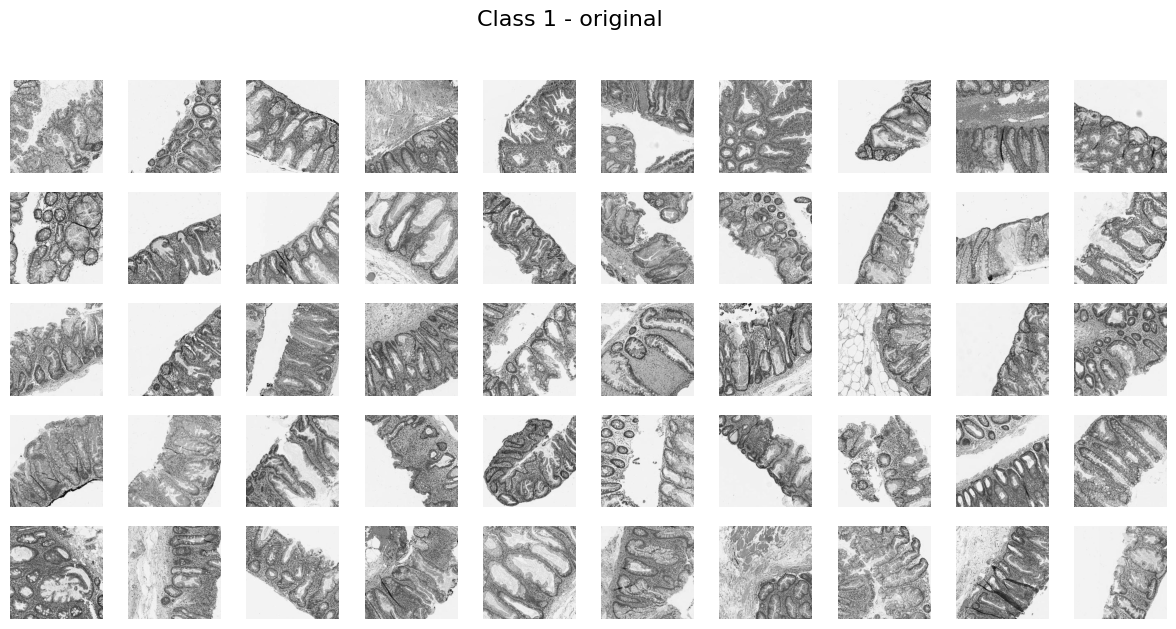

Image grids saved to mhist_result/grey_original_grid


In [21]:
img_syn_loaded = torch.load('mhist_result/grey__synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='original')

#### random noise

In [42]:
# set up the synthetic dataset
import random

num_classes = 2
num_images_per_class = 50
img_size = (1, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            img_real = real_dataset[i][0].to(device)

            noisy_versions = []
            for k_init in range(K):
                noise = torch.rand(size=img_real.shape, requires_grad=True).to(device)
                noisy_image = torch.clamp(img_real + noise, 0, 1).clone().detach().requires_grad_(True)
                noisy_versions.append(noisy_image)

            for k_init in range(K):
                noisy_image = noisy_versions[k_init]
                optimizer_condensed = optim.SGD([noisy_image], lr=eta_s)

                for step in range(zeta_s):
                    optimizer_condensed.zero_grad()
                    loss = torch.nn.functional.mse_loss(noisy_image, img_real)
                    loss.backward()
                    optimizer_condensed.step()

            selected_synthetic_image = torch.mean(torch.stack(noisy_versions), dim=0).detach()

            synthetic_images.append(selected_synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

            selected_synthetic_image = noisy_versions[0].detach()
            synthetic_images.append(selected_synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

In [43]:
img_syn, labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

In [44]:
img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Random')

Iteration 1/10
[2024-10-26 03:47:06] iter = 00000, loss = 0.4184
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/grey_Random_synthetic_dataset.pt
Training losses saved to mhist_result/Random_training_losses.txt


<ipython-input-22-cc1522998ae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')


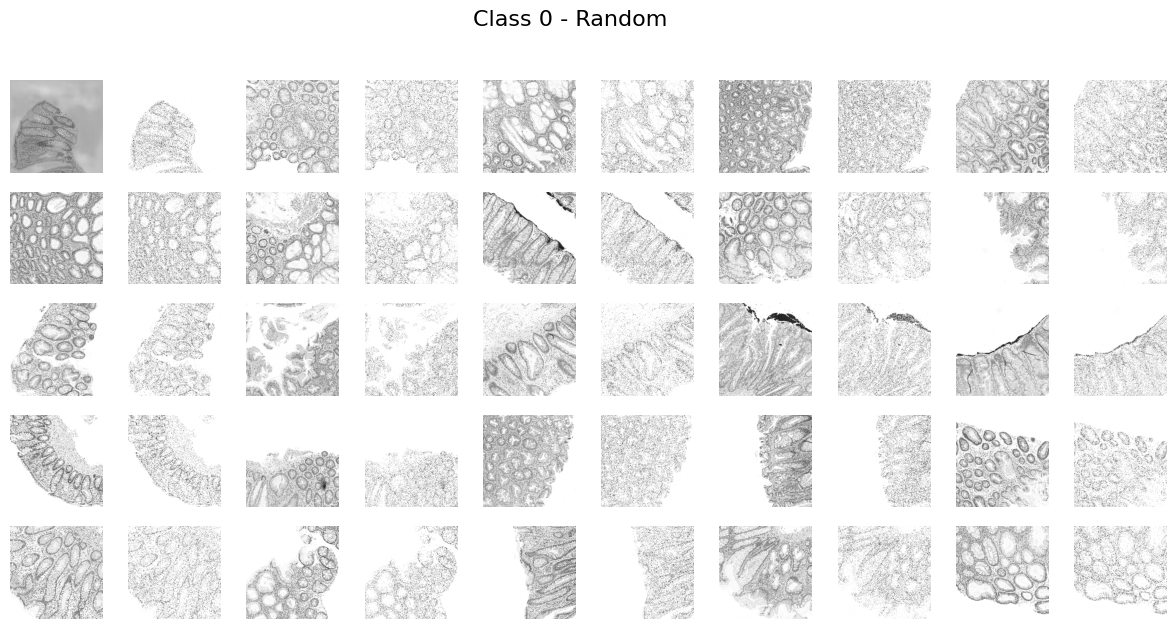

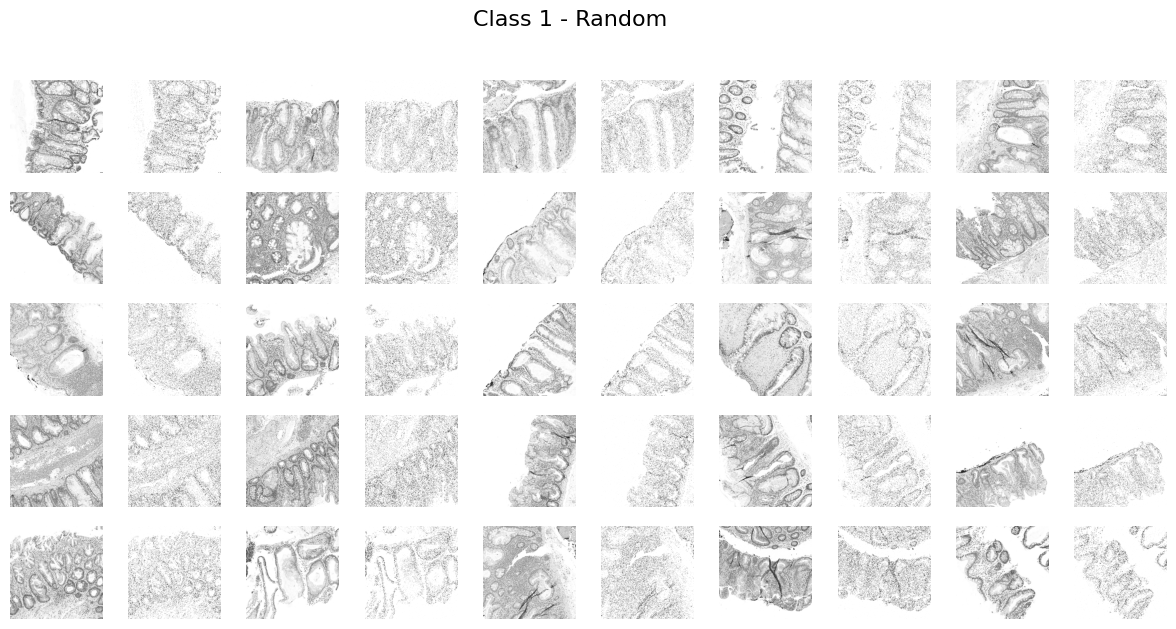

Image grids saved to mhist_result/grey_Random_grid


In [22]:
img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Random')

In [46]:
# 2d
def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            img_real = real_dataset[i][0].to(device)

            noisy_versions = []
            for k_init in range(K):
                noise = torch.normal(mean=0, std=noise_std, size=img_real.shape, requires_grad=True).to(device)
                noisy_image = torch.clamp(img_real + noise, 0, 1).clone().detach().requires_grad_(True)
                noisy_versions.append(noisy_image)

            for k_init in range(K):
                noisy_image = noisy_versions[k_init]
                optimizer_condensed = optim.SGD([noisy_image], lr=eta_s)

                for step in range(zeta_s):
                    optimizer_condensed.zero_grad()
                    loss = torch.nn.functional.mse_loss(noisy_image, img_real)
                    loss.backward()
                    optimizer_condensed.step()

            selected_synthetic_image = torch.mean(torch.stack(noisy_versions), dim=0).detach()

            synthetic_images.append(selected_synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

img_syn, labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)
img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Gaussian')

Iteration 1/10
[2024-10-26 03:51:40] iter = 00000, loss = 5.4356
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/grey_Gaussian_synthetic_dataset.pt
Training losses saved to mhist_result/Gaussian_training_losses.txt


<ipython-input-23-f387b7e2cf92>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')


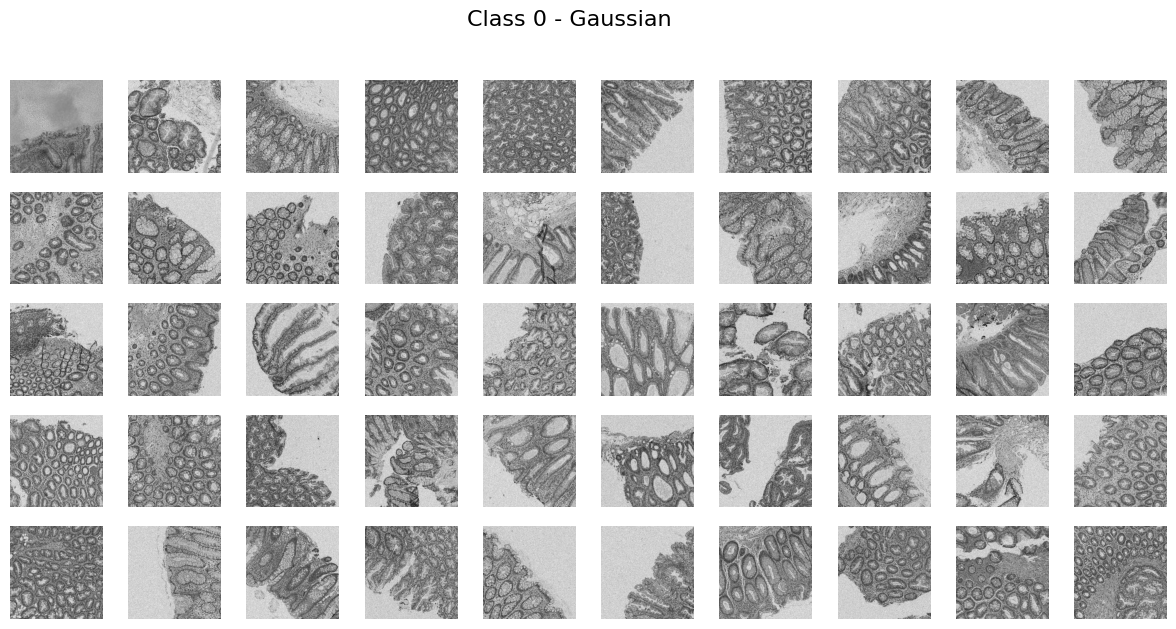

In [ ]:
img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Gaussian')

##### 2e) Train the model with condensed dataset

In [14]:
random_model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
random_optimizer = SGD(random_model.parameters(), lr=0.01, momentum=0.9)

gaussian_model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
gaussian_optimizer = SGD(gaussian_model.parameters(), lr=0.01, momentum=0.9)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [15]:
from torch.utils.data import TensorDataset, DataLoader

img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_model, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-15-39a68d36b76a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6653795218467713
Epoch [2/20], Loss: 0.577146110534668
Epoch [3/20], Loss: 0.4760445261001587
Epoch [4/20], Loss: 0.35603985786437986
Epoch [5/20], Loss: 0.24064055144786833
Epoch [6/20], Loss: 0.14171695351600647
Epoch [7/20], Loss: 0.08608404070138931
Epoch [8/20], Loss: 0.0675678551197052
Epoch [9/20], Loss: 0.08735677510499955
Epoch [10/20], Loss: 0.04235950484871864
Epoch [11/20], Loss: 0.02769987493753433
Epoch [12/20], Loss: 0.01574888050556183
Epoch [13/20], Loss: 0.012122929580509662
Epoch [14/20], Loss: 0.009199855849146843
Epoch [15/20], Loss: 0.008234874773770572
Epoch [16/20], Loss: 0.007503322213888168
Epoch [17/20], Loss: 0.007163753882050514
Epoch [18/20], Loss: 0.006974675450474024
Epoch [19/20], Loss: 0.006880321651697159
Epoch [20/20], Loss: 0.006847841143608094


In [16]:

img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_model, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-16-71572dd44289>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6818539094924927
Epoch [2/20], Loss: 0.6792648959159852
Epoch [3/20], Loss: 0.6806079268455505
Epoch [4/20], Loss: 0.5906803154945374
Epoch [5/20], Loss: 0.5624461197853088
Epoch [6/20], Loss: 0.4945949411392212
Epoch [7/20], Loss: 0.44274606704711916
Epoch [8/20], Loss: 0.4076852321624756
Epoch [9/20], Loss: 0.31700455844402314
Epoch [10/20], Loss: 0.2678124570846558
Epoch [11/20], Loss: 0.25575762301683425
Epoch [12/20], Loss: 0.17899298310279846
Epoch [13/20], Loss: 0.15200209438800813
Epoch [14/20], Loss: 0.1322044003009796
Epoch [15/20], Loss: 0.10992834955453873
Epoch [16/20], Loss: 0.09656143963336944
Epoch [17/20], Loss: 0.08145302414894104
Epoch [18/20], Loss: 0.07612305581569671
Epoch [19/20], Loss: 0.07547390416264534
Epoch [20/20], Loss: 0.0744376078248024


In [13]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
evaluate_model(random_model, test_loader)

Test Accuracy: 48.93%


In [19]:
evaluate_model(gaussian_model, test_loader)

Test Accuracy: 56.70%


#### 3 Cross-Architecture Generalization

In [58]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

In [59]:
random_resnet = ResNet18(channel=1, num_classes=2)
random_optimizer = SGD(random_resnet.parameters(), lr=0.01, momentum=0.9)
random_resnet.to(device)

gaussian_resnet = ResNet18(channel=1, num_classes=2)
gaussian_optimizer = SGD(gaussian_resnet.parameters(), lr=0.01, momentum=0.9)
gaussian_resnet.to(device)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [60]:
img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_resnet, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-60-c03c58f65e8a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 17.177269649505615
Epoch [2/20], Loss: 10.095754661560058
Epoch [3/20], Loss: 6.432760887145996
Epoch [4/20], Loss: 9.151259689331054
Epoch [5/20], Loss: 5.322260298728943
Epoch [6/20], Loss: 2.604643545150757
Epoch [7/20], Loss: 2.224268774986267
Epoch [8/20], Loss: 0.8426822417788208
Epoch [9/20], Loss: 0.6476650157570839
Epoch [10/20], Loss: 0.3116000069369329
Epoch [11/20], Loss: 0.21446602859534322
Epoch [12/20], Loss: 0.08777500150725245
Epoch [13/20], Loss: 0.02088975943624973
Epoch [14/20], Loss: 0.019191951528191566
Epoch [15/20], Loss: 0.011919197160750628
Epoch [16/20], Loss: 0.008177206933032722
Epoch [17/20], Loss: 0.005633335305028595
Epoch [18/20], Loss: 0.00484400218942028
Epoch [19/20], Loss: 0.004697848892210459
Epoch [20/20], Loss: 0.004635609518736601


In [61]:
img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_resnet, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-61-a60454633641>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/grey_Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 28.874161109924316
Epoch [2/20], Loss: 36.47516632080078
Epoch [3/20], Loss: 15.596735610961915
Epoch [4/20], Loss: 6.851581535339355
Epoch [5/20], Loss: 79.25105979919434
Epoch [6/20], Loss: 28.124497842788696
Epoch [7/20], Loss: 16.039196367263795
Epoch [8/20], Loss: 9.987393174730242
Epoch [9/20], Loss: 12.07059757232666
Epoch [10/20], Loss: 16.565221786499023
Epoch [11/20], Loss: 7.782271118164062
Epoch [12/20], Loss: 7.10174108505234
Epoch [13/20], Loss: 7.144033966064453
Epoch [14/20], Loss: 3.3529790878295898
Epoch [15/20], Loss: 5.879345903396606
Epoch [16/20], Loss: 2.3162321996688844
Epoch [17/20], Loss: 3.4123265457153322
Epoch [18/20], Loss: 1.8043689250946044
Epoch [19/20], Loss: 1.9125572836399078
Epoch [20/20], Loss: 1.92740740776062


In [62]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
evaluate_model(random_resnet, test_loader)

Test Accuracy: 53.63%


In [64]:
evaluate_model(gaussian_resnet, test_loader)

Test Accuracy: 58.44%
